# Simple Linear Regression


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colormaps import get_segmented_cmap
from feature_sets import feature_sets
from scipy.stats import ttest_1samp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from utils.paths import EXTRACTED_FEATURES_DIR

In [2]:
# Colour Maps
cmap_seg = get_segmented_cmap()

In [3]:
# Dataset
features_df = pd.read_csv(EXTRACTED_FEATURES_DIR / 'final_features.csv')

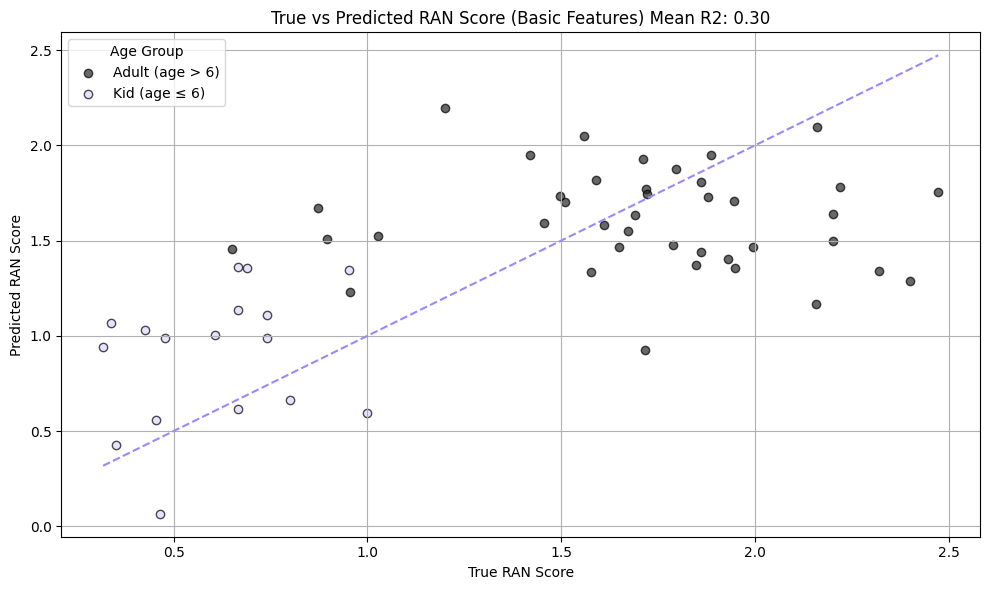

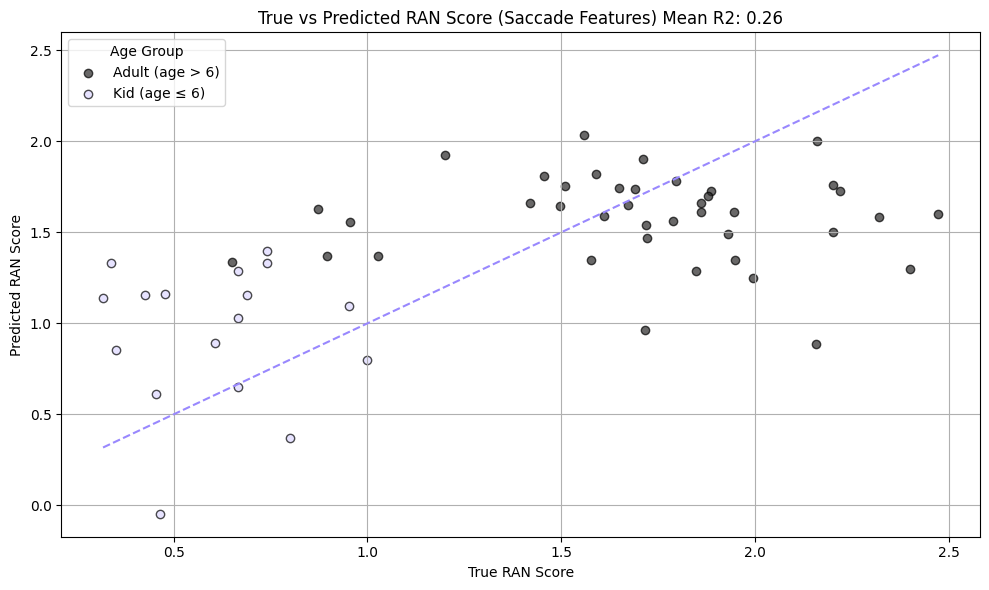

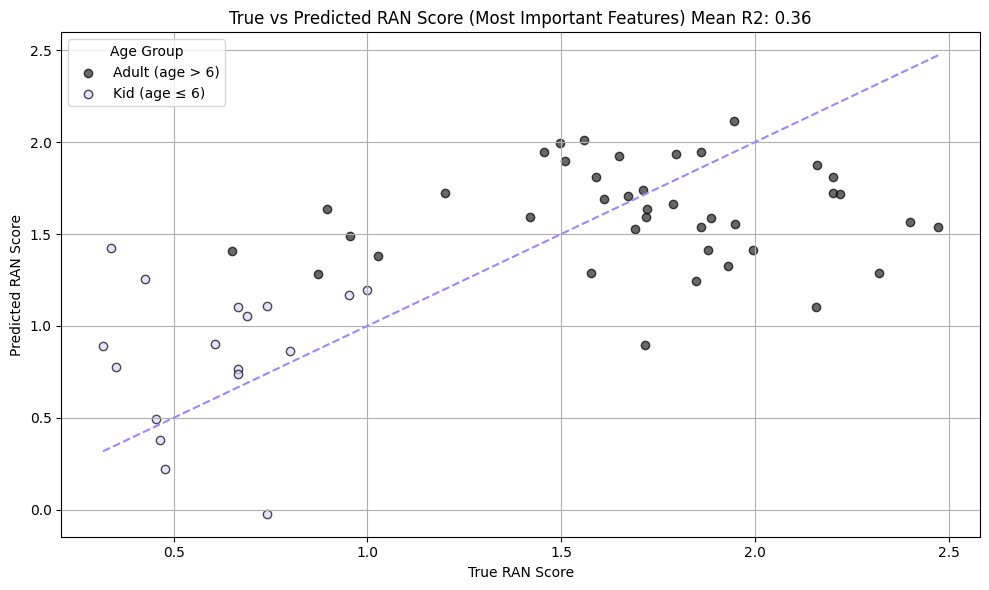

,Feature_Set,R2_Mean,R2_Std,R2_Full,MAE,MSE,RMSE,R2_pval
0,Basic,0.303989,0.134710,0.362307,0.410684,0.249531,0.499531,0.010714
4,Saccade,0.262552,0.170626,0.306304,0.433940,0.271446,0.521005,0.037021
7,Most Important,0.358686,0.247141,0.388359,0.401994,0.239337,0.489221,0.043999
2,Spatial,0.318117,0.242391,0.387193,0.388220,0.239793,0.489687,0.058502
6,Blinks,-0.026886,0.044389,0.051741,0.502918,0.371057,0.609144,0.292423
9,All,-16.129879,32.752526,-10.192658,0.659367,4.379726,2.092780,0.380409
5,Latency,-0.077271,0.187433,0.027678,0.546945,0.380473,0.616825,0.455973
3,Fixation,0.071727,0.228536,0.146848,0.495974,0.333841,0.577790,0.564247
8,AOI,-0.129639,0.552342,-0.013530,0.505863,0.396598,0.629760,0.663217
1,Significant,-0.051028,1.112199,0.181330,0.380850,0.320349,0.565993,0.931300


In [ ]:
# Define target variable for regression
y = features_df["ran_score"]

# Define evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

for name, feature_list in feature_sets.items():
    X = features_df[feature_list].copy()

    pipeline = Pipeline(
        [("scaler", StandardScaler()), ("regressor", LinearRegression())]
    )

    # Cross-validated predictions
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)

    # Cross-validated R2 scores
    r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="r2")

    # One-sample t-test against R2=0
    t_stat, p_value = ttest_1samp(r2_scores, 0)

    # Overall evaluation
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    results.append(
        {
            "Feature_Set": name,
            "R2_Mean": r2_scores.mean(),
            "R2_Std": r2_scores.std(),
            "R2_Full": r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2_pval": p_value
        }
    )

    if p_value < 0.05:
        # Split by age group
        is_adult = features_df["age"] > 6
        is_kid = ~is_adult

        # Plot true vs predicted
        plt.figure(figsize=(10, 6))
        
        # Plot adults
        plt.scatter(
            y[is_adult],
            y_pred[is_adult],
            c=cmap_seg[6],
            edgecolor="k",
            alpha=0.7,
            label="Adult (age > 6)",
        )

        # Plot kids
        plt.scatter(
            y[is_kid],
            y_pred[is_kid],
            c=cmap_seg[1],
            edgecolor="k",
            alpha=0.7,
            label="Kid (age ≤ 6)",
        )
        plt.legend(title="Age Group")
        plt.plot([y.min(), y.max()], [y.min(), y.max()], "--", color=cmap_seg[3])
        plt.title(
            f"True vs Predicted RAN Score ({name} Features) Mean R2: {r2_scores.mean():.2f}"
        )
        plt.xlabel("True RAN Score")
        plt.ylabel("Predicted RAN Score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R2_pval", ascending=True)

results_df